In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import jdc        # jupyter dynamic classes


In [2]:

class CryptoPricePrediction:
    # Cryptocurrency and fiat currency its price is measured against.
    crypto_currency = 'BTC'
    fiat_currency = 'USD'
    
    def __init__(self, coin=crypto_currency, currency=fiat_currency, window_len=5, test_size=0.2, zero_base=True, 
                 lstm_neurons=100, epochs=50, batch_size=32, dropout=0.2, loss='mse', optimizer='adam'):

        self.df = pd.DataFrame()

        self.coin = coin
        self.currency = currency
        self.window_len = window_len
        self.test_size = test_size
        self.zero_base = zero_base
        self.lstm_neurons = lstm_neurons
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.loss = loss
        self.optimizer = optimizer

        self.endpoint = 'https://min-api.cryptocompare.com/data/histoday'

        self.hist = self._get_historical_data()
        self.hist.drop(["conversionType", "conversionSymbol"], axis='columns', inplace=True)

        self.train, self.test, self.X_train, self.X_test, self.y_train, self.y_test = self._prepare_data()
        self.model = self._build_lstm_model(self.X_train, output_size=1)

        

In [3]:
 
    %%add_to CryptoPricePrediction
    def _prepare_data(self):
        # Create windowed dataset
        window_data = []
        for idx in range(len(self.hist) - self.window_len):
            window_data.append(self.hist[idx: idx + self.window_len])

        window_data = np.array(window_data)

        # Normalize target variable (price)
        target_data = self.normalize_target_variable(self.hist['close'], self.hist['close'].values)

        # Train-test split
        split_idx = int(self.test_size * window_data.shape[0])
        X_train, X_test = window_data[:-split_idx], window_data[-split_idx:]
        y_train, y_test = target_data[:-split_idx], target_data[-split_idx:]

        train = self.hist.iloc[:len(self.hist)-split_idx]
        test = self.hist.iloc[len(self.hist)-split_idx:]

        return train, test, X_train, X_test, y_train, y_test



In [4]:
  
    %%add_to CryptoPricePrediction

    def _get_historical_data(self):
        res = requests.get(f'{self.endpoint}?fsym={self.coin}&tsym={self.currency}&limit=500')
        hist = pd.DataFrame(json.loads(res.content)['Data'])
        hist = hist.set_index('time')
        hist.index = pd.to_datetime(hist.index, unit='s')
        return hist
    

In [5]:

    %%add_to CryptoPricePrediction
    def _train_test_split(self, df):
        split_row = len(df) - int(self.test_size * len(df))
        train_data = df.iloc[:split_row]
        test_data = df.iloc[split_row:]
        return train_data, test_data
    

In [6]:

    %%add_to CryptoPricePrediction
    def to_zero_base_normalization(self, df):
        """
        The to_zero_base_normalization method takes a pandas
        DataFrame as input and returns a normalized version 
        of that DataFrame where each value is scaled to a base of 0,
        which means that the first value in each column
        is subtracted from all other values in the same column.
        """
        # Validate input parameter
        if not isinstance(df, pd.DataFrame) or df.empty:
            raise ValueError('df must be a non-empty pandas DataFrame')
        
        return df.div(df.iloc[0]).sub(1)
    

In [7]:

    %%add_to CryptoPricePrediction
    def _normalise_min_max(self, df):
        """
        The to_min_max_normalization function takes 
        a pandas DataFrame as input and returns a normalized 
        version of that DataFrame where each value is scaled
        to a range between 0 and 1 based on the minimum 
        and maximum values of the input DataFrame.
        """
        # Validate input parameter
        if not isinstance(df, pd.DataFrame) or df.empty:
            raise ValueError('df must be a non-empty pandas DataFrame')

        return (df - df.min()) / (df.max() - df.min())
    

In [8]:

    %%add_to CryptoPricePrediction
    def extract_window_data(self, data):
        """
        The extract_window_data method takes a DataFrame 
        and generates rolling windows of a specified length 
        from it, and optionally normalizes the data to have a zero base.
        """
        # Validate input parameters
        if not isinstance(data, pd.DataFrame) or data.empty:
            raise ValueError('data must be a non-empty pandas DataFrame')

        window_data = []
        for idx in range(len(data) - self.window_len):
            tmp = data.iloc[idx: (idx + self.window_len)].copy()
            if self.zero_base:
                tmp = tmp / tmp.iloc[0] - 1
            window_data.append(tmp.values)

        return np.array(window_data)


In [9]:

    %%add_to CryptoPricePrediction
    def extract_target_variable(self, train_data, test_data, col):
        train_target = train_data[col][self.window_len:].values
        test_target = test_data[col][self.window_len:].values
        return train_target, test_target
    

In [10]:

    %%add_to CryptoPricePrediction
    def normalize_target_variable(self, target_var, prev_val):
        # Zero-centered normalization
        norm_target = target_var[self.window_len:] / prev_val[:-self.window_len] - 1
        return norm_target

    

In [11]:

    %%add_to CryptoPricePrediction
    def _build_lstm_model(self, input_data, output_size, neurons=None, activ_func='linear', dropout=None, loss=None, optimizer=None):
        model = Sequential()
        model.add(LSTM(self.lstm_neurons if neurons is None else neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
        model.add(Dropout(self.dropout if dropout is None else dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss=self.loss if loss is None else loss, optimizer=self.optimizer if optimizer is None else optimizer)
        return model



In [12]:

    %%add_to CryptoPricePrediction
    def prepare_and_train(self):
        train, test, X_train, X_test, y_train, y_test = self._prepare_data()

        model = self._build_lstm_model(
            X_train, output_size=1, neurons=self.lstm_neurons, dropout=self.dropout, loss=self.loss,
            optimizer=self.optimizer)

        history = model.fit(
            X_train, y_train, validation_data=(X_test, y_test), epochs=self.epochs, batch_size=self.batch_size, verbose=1, shuffle=True)

        return train, test, model, history


    

In [13]:
 
    %%add_to CryptoPricePrediction
    def plot_loss(self, history):
        # Get loss history
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Plot loss history
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

#### Evaluate the model

In [14]:
    
    %%add_to CryptoPricePrediction    
    def evaluate_model(self, X_test, y_test, targets, target_col='close', window_len=None):
        window_len = self.window_len if window_len is None else window_len

        preds = self.model.predict(X_test).squeeze()
        mae = mean_absolute_error(preds, y_test)
        mse = mean_squared_error(preds, y_test)
        r2 = r2_score(y_test, preds)
        print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2 score: {r2:.4f}')

        preds = targets[target_col].values[:-window_len] * (preds + 1)
        preds = pd.Series(index=targets.index, data=preds)
        self.line_plot(targets, preds, 'actual', 'prediction', lw=3)



Epoch 1/20
13/13 [==============================] - 2s 35ms/step - loss: 0.4217 - val_loss: 0.1884
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1991 - val_loss: 0.0327
Epoch 3/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1413 - val_loss: 0.0058
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1189 - val_loss: 0.0059
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1157 - val_loss: 0.0088
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1323 - val_loss: 0.0101
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1157 - val_loss: 0.0080
Epoch 8/20
13/13 [==============================] - 0s 7ms/step - loss: 0.1159 - val_loss: 0.0069
Epoch 9/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1008 - val_loss: 0.0084
Epoch 10/20
13/13 [==============================] - 0s 6ms/step - loss: 0.1024 - val_loss: 0.0118
Epoch 11/20
13/13 

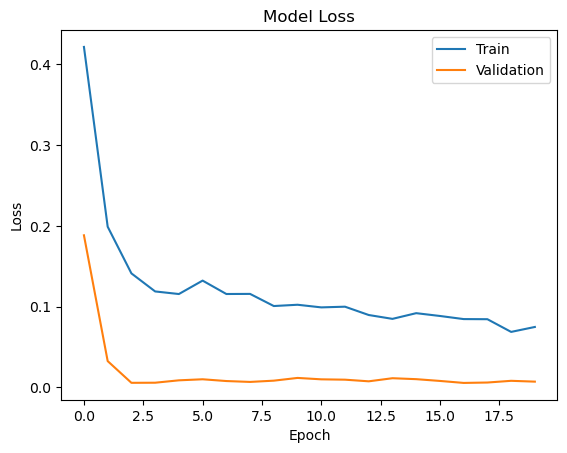

In [16]:
instance = CryptoPricePrediction()
train, test, model, history = instance.prepare_and_train()
instance.plot_loss(history)